# **Setting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from torchsummary import summary
import time
import copy

import random

import os

In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 14.5 MB/s 
     |████████████████████████████████| 182 kB 70.1 MB/s 


In [4]:
from torchvision import datasets as ds
from torch.utils.data import DataLoader
from torchvision import transforms as ts
import torchvision as tv
import torch
import torch.nn as nn
import math
import numpy as np
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
import torch.backends.cudnn as cudnn
import timm
from PIL import Image
from tqdm import tqdm
import random
import os

%config Completer.use_jedi = False

In [5]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-2
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(config.seed)

In [6]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

device

device(type='cuda')

# **Dataset**

In [7]:
transform  = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)

vaildset = torchvision.datasets.CIFAR10(root='/data',
                                        train=False,
                                        download=True,
                                        transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [9]:
testset = torchvision.datasets.ImageFolder(root = "./drive/MyDrive/Statistical_Deep_Image",
                                           transform = transform)

In [10]:
train_loader = DataLoader(trainset,
                          batch_size = 64,
                          shuffle=True,
                          num_workers=2)

vaild_loader = DataLoader(vaildset,
                          batch_size = 64,
                          shuffle=True,
                          num_workers=2)


test_loader = DataLoader(testset,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)

#**Model**

In [11]:
import os, sys
import math
import torch
import torch.nn as nn
import numpy as np

def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1):
	return nn.Sequential(
			nn.Conv2d(in_channels,
					  out_channels,
					  kernel_size=kernel_size,
					  stride=stride,
					  padding=kernel_size//2,
					  bias=False), 
			nn.BatchNorm2d(out_channels),
			nn.ReLU(inplace=False))

def conv_bn(in_channels, out_channels, kernel_size=3, stride=1):
	return nn.Sequential(
			nn.Conv2d(in_channels,
					  out_channels,
					  kernel_size=kernel_size,
					  stride=stride,
					  padding=kernel_size//2,
					  bias=False), 
			nn.BatchNorm2d(out_channels))
	
class Aggregation(nn.Module):
	def __init__(self, in_channels, out_channels):
		super(Aggregation, self).__init__()
		self.aggregation = conv_bn_relu(in_channels, out_channels, kernel_size=1)
	def forward(self, *x):
		x = torch.cat(x, dim=1)
		return self.aggregation(x)

class BasicBlock(nn.Module):
	def __init__(self, in_channels, out_channels, stride=1):
		super(BasicBlock, self).__init__()
		
		if stride == 1:
			self.shortcut = nn.Identity()
		else:
			self.shortcut = nn.Sequential(nn.MaxPool2d(2),
										  conv_bn(in_channels, out_channels, kernel_size=1))
		
		self.conv1 = conv_bn_relu(in_channels, out_channels, stride=stride)
		self.conv2 = conv_bn(out_channels, out_channels)
		
	def forward(self, x):
		return torch.relu(self.shortcut(x) + self.conv2(self.conv1(x)))

class HDATree(nn.Module):
	def __init__(self,
				 depth,
				 aggregate_root,
				 root_channels,
				 in_channels,
				 out_channels,
				 stride=1,
				 block=BasicBlock):
		super(HDATree, self).__init__()
		
		self.depth = depth
		self.aggregate_root = aggregate_root
  
		if root_channels == 0:
			root_channels = out_channels * 2
		
		if aggregate_root:
			root_channels += in_channels
			self.downsample = nn.MaxPool2d(2)
		
		if depth == 1:
			self.child1 = block(in_channels, out_channels, stride)
			self.child2 = block(out_channels, out_channels)
			self.aggregation = Aggregation(root_channels, out_channels)
		else: #recursively generate layers
			self.child1 = HDATree(depth=depth-1, 
								  aggregate_root=False, 
								  root_channels=0,
								  in_channels=in_channels, 
								  out_channels=out_channels,
								  stride=stride)
			self.child2 = HDATree(depth=depth-1, 
								  aggregate_root=False, 
								  root_channels=root_channels + out_channels,
								  in_channels=out_channels, 
								  out_channels=out_channels)
		
	def forward(self, x, aggregated_features=None):
		if aggregated_features is None:
			aggregated_features = []
   
		if self.aggregate_root:
			aggregated_features.append(self.downsample(x))
		
		x1 = self.child1(x)
		if self.depth == 1:
			x2 = self.child2(x1)
			x = self.aggregation(x1, x2, *aggregated_features)
		else:
			aggregated_features.append(x1)
			x = self.child2(x1, aggregated_features)
			
		return x


class DLA(nn.Module):
	def __init__(self,
				 stages_depth,
				 channels,
				 num_classes=10,
				 block=BasicBlock):
		super(DLA, self).__init__()

		#Refer to 4.1. Classification Networks in paper "Deep Layer Aggregation"
		
		#"basic block" means conv_bn_relu layer in stage1 and stage2 and means one of three types of residual blocks in all other stages.
		
		#The stage 1 is composed of a 7×7 convolution followed by a basic block.
		self.stage1 = conv_bn_relu(3, channels[0], stride=2)
		
		#The stage 2 is only a basic block.
		self.stage2 = conv_bn_relu(channels[0], channels[1], stride=2)
		
		#For all other stages, we make use of combined IDA and HDA on the backbone blocks and stages.
		
		self.stage3 = HDATree(depth=stages_depth[2], 
							  aggregate_root=False, 
							  root_channels=0, 
							  in_channels=channels[1], 
							  out_channels=channels[2],
		 					  stride=2)
		
		self.stage4 = HDATree(depth=stages_depth[3], 
							  aggregate_root=True, 
							  root_channels=0, 
							  in_channels=channels[2], 
							  out_channels=channels[3],
		 					  stride=2)
		
		self.stage5 = HDATree(depth=stages_depth[4], 
							  aggregate_root=True, 
							  root_channels=0, 
							  in_channels=channels[3], 
							  out_channels=channels[4],
		 					  stride=2)
	   
		self.stages = nn.ModuleList([self.stage1, self.stage2, self.stage3, self.stage4, self.stage5])
		
		self.gap = nn.AdaptiveAvgPool2d((1, 1))#global average pooling
		self.fc = nn.Conv2d(channels[4], num_classes, kernel_size=1, stride=1, padding=0, bias=True)

		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
			elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
				nn.init.constant_(m.weight, 1.)
				nn.init.constant_(m.bias, 0.)

	def forward(self, x):
		y = []
		
		for stage in self.stages:
			x = stage(x)
			y.append(x)
		
		print(x.shape)
		x = self.gap(x)
		x = self.fc(x)
		x = x.flatten(start_dim=1)
		return x

In [12]:
#모델뒤 이름, 클래스 수 인풋사이즈 변경
model = DLA([1, 1, 1, 2, 1], [32, 64, 128, 256, 512])

In [13]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 32, 32), device=device.type)

torch.Size([2, 512, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
            Conv2d-2           [-1, 32, 16, 16]             864
       BatchNorm2d-3           [-1, 32, 16, 16]              64
       BatchNorm2d-4           [-1, 32, 16, 16]              64
              ReLU-5           [-1, 32, 16, 16]               0
              ReLU-6           [-1, 32, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          18,432
            Conv2d-8             [-1, 64, 8, 8]          18,432
       BatchNorm2d-9             [-1, 64, 8, 8]             128
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
             ReLU-12             [-1, 64, 8, 8]               0
        MaxPool2d-13             [-1, 64, 4, 4]               0
        MaxP

In [14]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)


from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=8)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [15]:
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_loader,
    'val_dl':vaild_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models_DLA/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models_DLA')
# 폴더이름 변경

In [16]:
model, loss_hist, metric_hist = train_val(model, params_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([

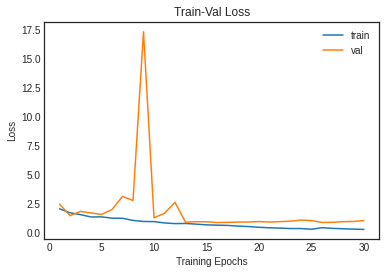

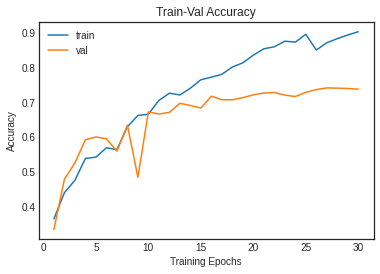

In [17]:
# Train-Validation progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [18]:
model.eval()

DLA(
  (stage1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (stage2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (stage3): HDATree(
    (child1): BasicBlock(
      (shortcut): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [19]:
total = 0
correct = 0
with torch.no_grad():
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs= model(images)
      _, predicted = torch.max(outputs.data,1)
      total +=labels.size(0)
      correct += (predicted == labels).sum().item()

print(100* correct/total)

torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([64, 512, 1, 1])
torch.Size([16, 512, 1, 1])
30.05
